In [76]:
import pandas as pd
import numpy as np
import os
from glob import glob
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical
# from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [60]:
from sklearn.metrics import classification_report,confusion_matrix
# from display_results import confusion_matrix

In [61]:
df_activity = pd.read_csv("activities.csv")

In [62]:
def get_activity_id(seg_id):
    seg = df_activity[df_activity["segment_id"]==seg_id]
    activity_id = seg["activity_id"].values
    return int(activity_id)

In [63]:
def segmentation(x_data,y,overlap_rate,time_window):
    seg_data,y_segmented = [],[]
    for x,y in zip(x_data,y):
        seg_,y_= segmentation_(x,y,overlap_rate,time_window)
        seg_data.extend(seg_)
        y_segmented.extend(y_)
    
    return np.array(seg_data),np.array(y_segmented)

def segmentation_(x_data,y,overlap_rate,time_window):
    
    x_data = np.array(x_data)
    seg_data = []
    overlap = int((1 - overlap_rate)*time_window)
    y_segmented_list = []
    
    for i in range(0,x_data.shape[0],overlap):
        if len(x_data[i:i+time_window]) == time_window:
            seg_data.append(x_data[i:i+time_window])
            y_segmented_list.append(y)
            
    return seg_data,y_segmented_list

In [64]:
def handle_missing_values(df):
    df['x']=df['x'].replace(0, np.nan)
    df['y']=df['y'].replace(0, np.nan)
    df['z']=df['z'].replace(0, np.nan)
    return df

In [65]:
def get_act_id(seg_id):
    seg = df_activity[df_activity["segment_id"]==seg_id]
    activity_id = seg["activity_id"].values
    return int(activity_id)

In [66]:
def load_data(csv_file):

    y_list = []
    x_data_list = []

    csv_df = pd.read_csv(csv_file)
    csv_df = handle_missing_values(csv_df)
    csv_df.dropna(inplace=True)
    x_data = csv_df.values
    act_id = get_act_id(int(os.path.splitext(os.path.basename(csv_file))[0].replace("segment","")))
    
    return x_data,act_id

In [67]:
# def get_features(x_data):
#     features = []
#     for i in range(x_data.shape[1]):
#         # std
#         features.append(x_data.T[i].std(ddof=0))
#         # avg
#         features.append(np.average(x_data.T[i]))
#         # max
#         features.append(np.max(x_data.T[i]))
#         # min
#         features.append(np.min(x_data.T[i]))
#     return features

In [68]:
def load_file(filepath):
    dataframe = pd.read_csv(filepath)
    return dataframe.values

In [79]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 1, 30, 32
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    # fit network
    history = model.fit(trainX, trainy, validation_data=(testX, testy), 
                        epochs=epochs, batch_size=batch_size, verbose=verbose)
    
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=1)
    return accuracy, history, model

In [70]:
# summarize scores
def summarize_results(scores):
    print('scores : ', scores)
    m, s = np.mean(scores), np.std(scores)
    print('Accuracy : %.3f%% (+/-%.3f)' % (m, s))

In [71]:
def visualize(trainX, trainy, testX, testy, history, model):
    
#     plt.figure(figsize=(6, 4))
#     plt.plot(history.history['acc'], 'r', label='Accuracy of training data')
#     plt.plot(history.history['val_acc'], 'b', label='Accuracy of validation data')
#     plt.plot(history.history['loss'], 'r--', label='Loss of training data')
#     plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
#     plt.title('Model Accuracy and Loss')
#     plt.ylabel('Accuracy and Loss')
#     plt.xlabel('Training Epoch')
#     plt.ylim(0)
#     plt.legend()
#     plt.savefig("cnn_acc_and_loss.png")
#     plt.show()

    # Print confusion matrix for training data
    y_pred_train = model.predict(trainX)
    # Take the class with the highest probability from the train predictions
    max_y_pred_train = np.argmax(y_pred_train, axis=1)
    #print(classification_report(trainy, max_y_pred_train))
    
    # confusion matrix
#     LABELS = ['VITAL_SIGNS_MEASUREMENTS',
#           'BLOOD_COLLECTION',
#           'BLOOD_GLUCOSE_MEASUREMENT',
#           'INDWELLING_DRIP_RETENTION_AND_CONNECTION',
#           'ORAL_CARE',
#           'DIAPER_EXCHANGE_AND_CLEANING_OF_AREA']
    LABELS = ["ID:2","ID:3","ID:4","ID:6","ID:9","ID:12"]
    y_pred_test = model.predict(testX)
    # Take the class with the highest probability from the test predictions
    max_y_pred_test = np.argmax(y_pred_test, axis=1)
    max_y_test = np.argmax(testy, axis=1)

    matrix = confusion_matrix(max_y_test, max_y_pred_test)
    plt.figure(figsize=(12, 8))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

In [72]:
# load the dataset, returns train and test X and y elements
def load_dataset():
    
    data_sets = []
    labels = []
    # load all train
    acc_csv_files =  glob("train/*")
    for acc_csv_file in acc_csv_files:
        data_sets.append(load_file(acc_csv_file))
        file_name = os.path.basename(acc_csv_file)
        seg_id = os.path.splitext(file_name)[0].replace("segment","")
        activity_id = get_activity_id(int(seg_id))
        labels.append(activity_id)
    
    labels = np.array(labels)
    # split 
    train_X,test_X,train_y,test_y = train_test_split(data_sets,labels,test_size=0.2,random_state=1)
#     # sampling 
#     train_sampling_data,train_label = Samplings(train_X,train_y,n=50,window_size=60)
#     test_sampling_data,test_label = Samplings(test_X,test_y,n=50,window_size=60)
    # segmentation
#     print("number of test x",len(test_X))
#     print("lenght of test x",len(test_X[0]))
#     print(test_y)
    train_segmented_data,y_train_segemented = segmentation(train_X,train_y,overlap_rate=0.5,time_window=60)
    
    test_segmented_data,y_test_segemented = segmentation(test_X,test_y,overlap_rate=0.5,time_window=60)
#     print(y_train_segemented)
#     print(y_test_segemented)
    # one hot encode y
    trainy = to_categorical(y_train_segemented )
    testy = to_categorical(y_test_segemented)
    print('trainX.shape : ', train_segmented_data.shape)
    print('trainy.shape : ', y_train_segemented.shape)
    print('testX.shape : ', test_segmented_data.shape)
    print('testy.shape : ', y_test_segemented.shape)
    return train_segmented_data, trainy, test_segmented_data, testy 

In [73]:
train_data,_,test,_ = load_dataset()

trainX.shape :  (430, 60, 3)
trainy.shape :  (430,)
testX.shape :  (100, 60, 3)
testy.shape :  (100,)


In [77]:
# run an experiment
def run_experiment(repeats =1):
    # load data
    trainX, trainy, testX, testy = load_dataset()
#     print(testX.shape)
#     print(trainy.shape)
    # repeat experiment
    
    scores = list()
    for r in range(repeats):
        score, history, model = evaluate_model(trainX, trainy, testX, testy)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
        # summarize results
    summarize_results(scores)
    visualize(trainX, trainy, testX, testy, history, model)

trainX.shape :  (430, 60, 3)
trainy.shape :  (430,)
testX.shape :  (100, 60, 3)
testy.shape :  (100,)
[[[-3.1020e+00 -9.2320e+00  3.8000e-02]
  [-4.5900e-01 -9.8450e+00  5.0000e-03]
  [-4.6730e+00 -7.9290e+00  1.0000e-02]
  ...
  [-3.9070e+00 -8.3120e+00  2.4100e-01]
  [-4.9410e+00 -8.0830e+00  2.6700e-01]
  [ 6.8900e-01 -9.0020e+00  3.6800e-01]]

 [[-1.9150e+00 -9.2700e+00  2.1300e-01]
  [-2.0300e+00 -9.2700e+00  1.9600e-01]
  [-2.0300e+00 -9.2700e+00  1.9600e-01]
  ...
  [-2.1450e+00 -9.4230e+00  1.9000e-02]
  [-1.7620e+00 -9.2320e+00  7.3000e-02]
  [-1.7620e+00 -9.2320e+00  7.3000e-02]]

 [[-7.6600e-01 -9.6920e+00  2.2000e-02]
  [-7.6600e-01 -9.6920e+00  2.2000e-02]
  [-7.2700e-01 -9.5770e+00  2.0000e-02]
  ...
  [-1.3400e+00 -8.9640e+00  4.1000e-01]
  [-1.3400e+00 -8.9640e+00  4.1000e-01]
  [-1.1490e+00 -9.2320e+00  3.8600e-01]]

 ...

 [[-6.5100e-01 -9.0400e+00  8.3000e-02]
  [-6.5100e-01 -9.0400e+00  8.3000e-02]
  [-2.3750e+00 -9.6150e+00  1.1600e-01]
  ...
  [-5.3600e-01 -2.6040

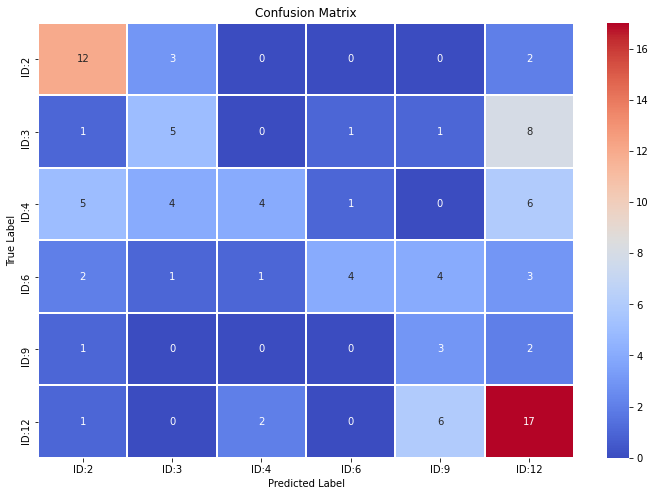

In [78]:
run_experiment()